In [1]:
%load_ext autoreload
%autoreload 2
import networkx as nx
import numpy as np
import pandas as pd
from genealogy_aligner import Pedigree
import matplotlib.pyplot as plt
from genealogy_aligner.Aligner import DescMatchingAligner
import msprime as msp
import io
from IPython.display import SVG, display

Text(0.5, 1.0, 'Coalescent tree')

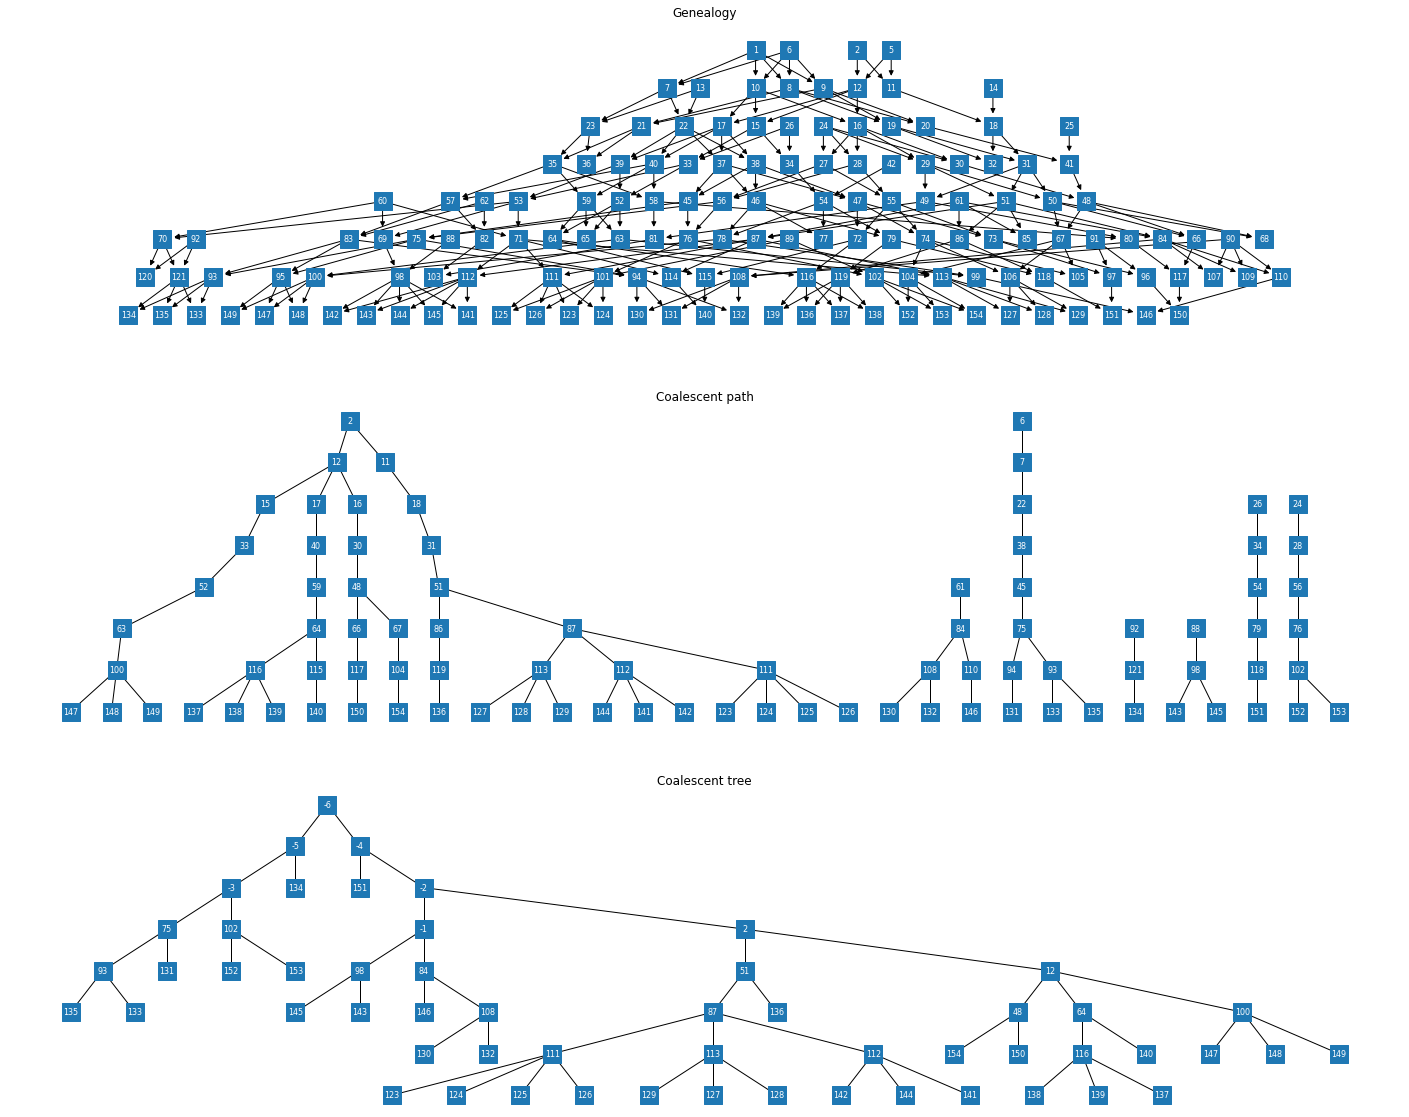

In [2]:
np.random.seed(724)

families = 5
generations = 7
avg_children = 2.2

gg = Pedigree.simulate_from_founders(families, generations, avg_children)

pt = gg.sample_path()
ct = pt.to_coalescent_tree()

fig, ax = plt.subplots(nrows=3, figsize=(25, 20))

gg.draw(ax=ax[0])
ax[0].set_title('Genealogy')
pt.draw(ax=ax[1])
ax[1].set_title('Coalescent path')
ct.draw(ax=ax[2])
ax[2].set_title('Coalescent tree')

In [3]:
algn = DescMatchingAligner(gg, ct)
algn.align()
algn.evaluate()

{'accuracy': 0.10204081632653061}

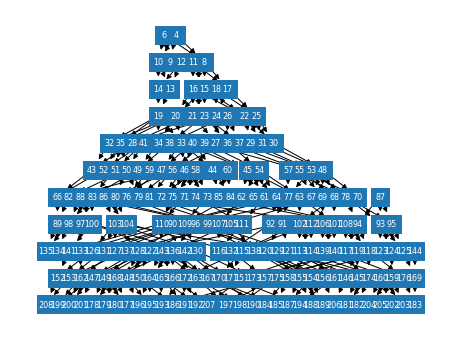

In [74]:
ped = Pedigree.simulate_from_founders(5, 10)

fig, ax = plt.subplots(figsize=(8, 6))

ped.draw(ax=ax)
plt.show()

sim, ts_ped_map, traversals = ped.generate_msprime_simulations()

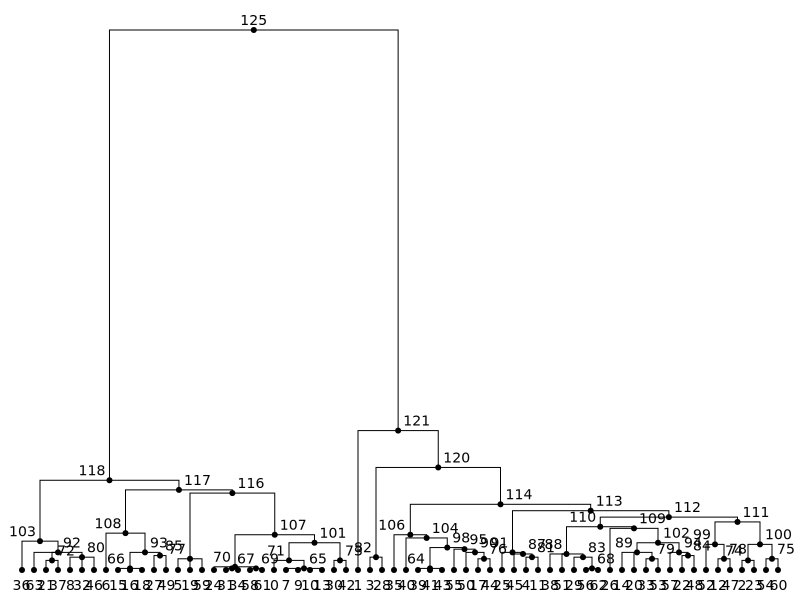

In [75]:
display(SVG(sim.first().draw(width=max(800, 2*len(ped.probands())), height=max(600, 2*len(ped.probands())))))

In [76]:
ts_ped_map

{0: 177,
 1: 177,
 2: 178,
 3: 178,
 4: 179,
 5: 179,
 6: 180,
 7: 180,
 8: 181,
 9: 181,
 10: 182,
 11: 182,
 12: 183,
 13: 183,
 14: 184,
 15: 184,
 16: 185,
 17: 185,
 18: 186,
 19: 186,
 20: 187,
 21: 187,
 22: 188,
 23: 188,
 24: 189,
 25: 189,
 26: 190,
 27: 190,
 28: 191,
 29: 191,
 30: 192,
 31: 192,
 32: 193,
 33: 193,
 34: 194,
 35: 194,
 36: 195,
 37: 195,
 38: 196,
 39: 196,
 40: 197,
 41: 197,
 42: 198,
 43: 198,
 44: 199,
 45: 199,
 46: 200,
 47: 200,
 48: 201,
 49: 201,
 50: 202,
 51: 202,
 52: 203,
 53: 203,
 54: 204,
 55: 204,
 56: 205,
 57: 205,
 58: 206,
 59: 206,
 60: 207,
 61: 207,
 62: 208,
 63: 208,
 67: 136,
 69: 136,
 70: 105}

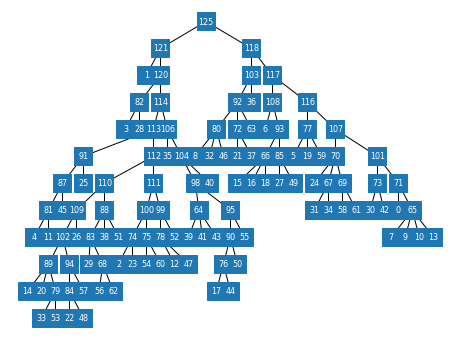

In [77]:
fig, ax = plt.subplots(figsize=(8, 6))

traversals[0].draw(ax=ax)